### Experiment with Copia module: book genres
This notebook explores the data on the survival of poetic books (1834-1850) stored in 10 library collections; books are manually provided with general genre tags, the groups are:
- col_lyr: poetry collections of lyrical texts (short poems);
- col_nar: colletcions of narrative poems (~epic poetry);
- sep_lyr: separate issues of one lyrical text (one-two pages brochures with a single poem);
- sep_nar: separate issues of one narrative poem;
- sep_drama: separate issue of a dramatic text in verse;
- alm_ : almanacs and collective issues (may also include prose);

#### Part I: Tests for each book genre for the whole period (1834-1850)

In [1]:
import os
import glob

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np
np.random.seed(1234)

In [111]:
import copia.utils as u
from copia.richness import *

from copia.utils import survival_ratio
from copia.utils import to_abundance, basic_stats

from copia.richness import species_accumulation

from copia.plot import abundance_histogram, accumulation_curve, multi_kde, survival_errorbar

In [62]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['ytick.minor.left'] = False

In [25]:
groups = {}
df = None

# import all separate .csv tables for the experiment as a dictionary of tables

for fh in sorted(glob.glob('/Users/tonya/Documents/thesis1830s/22_02_poetry_collections_biblio/github_main/data/experiment/exp_*.csv')):
    df = pd.read_csv(fh)
    df = df.iloc[:,1:]
    genre = os.path.basename(fh).replace('.csv','').replace('exp_','').lower()
    groups[genre] = df[['work', 'signature']]

In [26]:
groups

{'alm_':                                                   work   signature
 0    _1834_49_Фл… Спин.._Незабудка: Московский Альм...       nlr_1
 1    _1834_49_Фл… Спин.._Незабудка: Московский Альм...         rsl
 2    _1834_49_Фл… Спин.._Незабудка: Московский Альм...       fi_sl
 3    _1836_121_NA_Маскерад. Подарок прекрасному пол...       nlr_1
 4    _1836_121_NA_Маскерад. Подарок прекрасному пол...         rsl
 ..                                                 ...         ...
 199  _1846_869_NA_Московский литературный и ученый ...      cz_slk
 200  _1847_870_NA_Московский литературный и ученый ...       nlr_1
 201  _1847_870_NA_Московский литературный и ученый ...         rsl
 202  _1847_870_NA_Московский литературный и ученый ...  us_harvard
 203  _1847_870_NA_Московский литературный и ученый ...      cz_slk
 
 [204 rows x 2 columns],
 'col_lyr':                                                   work   signature
 0    1834_5_Батюшков К._Сочинения в прозе и стихах ...       nlr_1
 1

In [34]:
# Basic stats calculation

stats = []

for genre, df in groups.items():
    abundance = u.to_abundance(df['work']) # convert to abundance data
    s = u.basic_stats(abundance) # basic stats function
    d = {'group': genre}
    # take f3 and f4 for well-survived groups
    for k in ('f1', 'f2', 'f3', 'f4', 'S', 'n'):
        d[k] = s[k]
    d['lib'] = len(set(df['signature']))
    stats.append(d)
    
# Conversion to df for easier use
stats_df = pd.DataFrame(stats)
stats_df

,group,f1,f2,f3,f4,S,n,lib
0,alm_,5,17,23,11,66,204,8
1,col_lyr,63,64,55,50,273,792,10
2,col_nar,2,4,2,5,20,75,8
3,sep_drama,4,12,9,8,37,107,8
4,sep_lyr,125,29,13,4,172,243,9
5,sep_nar,59,64,32,15,180,396,10


In [47]:
# Estimations for original works with different estimators

populations = {}

for genre, df in groups.items():
    abundance = u.to_abundance(df['work'])
    populations[genre.title()] = abundance

for genre, population in populations.items():
    print('genre:', genre)
    for m in ('chao1', 'ichao1', 'egghe_proot'):
        print(' - ', m, '->', diversity(population, method = m))

genre: Alm_
 -  chao1 -> 66.73168973471742
 -  ichao1 -> 66.73168973471742
 -  egghe_proot -> 66.08182844768388
genre: Col_Lyr
 -  chao1 -> 303.9686612215909
 -  ichao1 -> 311.61366122159086
 -  egghe_proot -> 314.2013922337636
genre: Col_Nar
 -  chao1 -> 20.493333333333332
 -  ichao1 -> 20.613333333333333
 -  egghe_proot -> 20.38326520587232
genre: Sep_Drama
 -  chao1 -> 37.66043613707165
 -  ichao1 -> 37.66043613707165
 -  egghe_proot -> 37.09943811164952
genre: Sep_Lyr
 -  chao1 -> 440.28792393926494
 -  ichao1 -> 503.56136143926494
 -  egghe_proot -> 461.45221580384424
genre: Sep_Nar
 -  chao1 -> 207.12663746843435
 -  ichao1 -> 207.12663746843435
 -  egghe_proot -> 203.24546773647992


In [48]:
# Minimum additional sample (lower bound on the true population size)

for genre, population in populations.items():
    print('genre:', genre)
    print(' - works : ', diversity(population, method = 'chao1'))
    print(' - documents : ', diversity(population, method = 'minsample'))

genre: Alm_
 - works :  66.73168973471742
 - documents :  282.8868788868789
genre: Col_Lyr
 - works :  303.9686612215909
 - documents :  3224.5512325512327
genre: Col_Nar
 - works :  20.493333333333332
 - documents :  107.7975327975328
genre: Sep_Drama
 - works :  37.66043613707165
 - documents :  150.12104312104313
genre: Sep_Lyr
 - works :  440.28792393926494
 - documents :  4684.218241218241
genre: Sep_Nar
 - works :  207.12663746843435
 - documents :  1511.2559152559152


In [64]:
# Survival ratios on density plot: works

wsurvival = {}
for genre, population in populations.items():
    wsurvival[genre] = survival_ratio(population, method = 'chao1')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 824.98it/s]


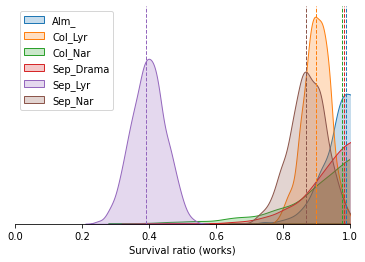

In [65]:
surv_density_w = multi_kde(wsurvival)
surv_density_w.set_xlabel('Survival ratio (works)')
surv_density_w.set_yticklabels([])
surv_density_w.tick_params(axis = 'y', which = 'both', left = False)
surv_density_w.spines['left'].set_visible(False)

#### Comparison of different estimators (works)

In [70]:
comp = []

for estim in ['chao1', 'ichao1', 'egghe_proot']:
    for genre, population in populations.items():
        surv = survival_ratio(population, method = estim, n_iter = 1000)
        comp.append([genre, estim, surv['survival'], surv['lci'], surv['uci']])

  0%|                                          | 1/1000 [00:01<17:42,  1.06s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|                                          | 1/1000 [00:01<17:19,  1.04s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|                                          | 1/1000 [00:01<17:19,  1.04s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|                                          | 1/1000 [00:01<17:18,  1.04s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:185: UserWarning: Add-one smoothing for P2 = 0
  warnings.warn("Add-one smoo

In [71]:
comp_df = pd.DataFrame(comp, columns = ['genre', 'estimator', 'survival_ratio', 'lower_ci', 'upper_ci'])

estimates = comp_df.sort_values(['genre', 'estimator'])
estimates.head()

,genre,estimator,survival_ratio,lower_ci,upper_ci
0,Alm_,chao1,0.989035,0.849014,1.105272
12,Alm_,egghe_proot,0.998762,0.682387,1.220242
6,Alm_,ichao1,0.989035,0.833405,1.126387
1,Col_Lyr,chao1,0.898119,0.820383,0.970257
13,Col_Lyr,egghe_proot,0.868869,0.751215,0.996848


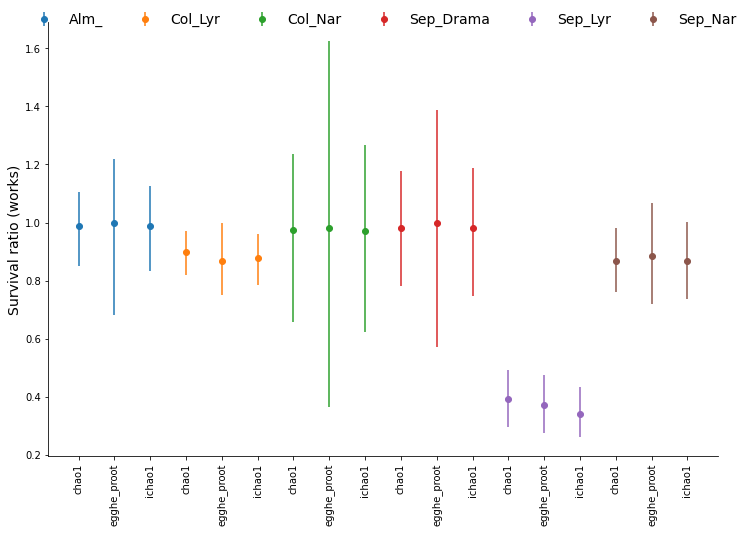

In [84]:
errors = np.array(list(zip(estimates['lower_ci'], estimates['upper_ci']))).T
errors[0] = estimates['survival_ratio'] - errors[0]
errors[1] -= estimates['survival_ratio']

fig, ax = plt.subplots(figsize=(12, 8))

genres = sorted(set(estimates['genre']))
color_dict = {t: f"C{i}" for i, t in enumerate(genres)}
labeled = {t:False for t in color_dict}

for idx in range(len(estimates)):
    genre = estimates['genre'].iloc[idx]
    meth = estimates['estimator'].iloc[idx]
    label = genre if not labeled[genre] else None
    c = color_dict[genre]
    labeled[genre] = True
    ax.errorbar(idx, estimates['survival_ratio'].iloc[idx],
        yerr=np.array([errors[:, idx]]).T,
        fmt='.', c=color_dict[genre], label=label,
        ms=12)

ax.set_ylabel('Survival ratio (works)', fontsize=14)
ax.set_xticks(np.arange(len(estimates)))
ax.set_xticklabels(estimates['estimator'], rotation = 90)
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='y', which='minor', left=True)
ax.legend(loc='upper center', ncol=len(populations), bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=14)



### Accumulation curves
- Lowest survival: 
    - sep_lyr
    - sep_nar
    - col_lyr

In [105]:
groups

{'alm_':                                                   work   signature
 0    _1834_49_Фл… Спин.._Незабудка: Московский Альм...       nlr_1
 1    _1834_49_Фл… Спин.._Незабудка: Московский Альм...         rsl
 2    _1834_49_Фл… Спин.._Незабудка: Московский Альм...       fi_sl
 3    _1836_121_NA_Маскерад. Подарок прекрасному пол...       nlr_1
 4    _1836_121_NA_Маскерад. Подарок прекрасному пол...         rsl
 ..                                                 ...         ...
 199  _1846_869_NA_Московский литературный и ученый ...      cz_slk
 200  _1847_870_NA_Московский литературный и ученый ...       nlr_1
 201  _1847_870_NA_Московский литературный и ученый ...         rsl
 202  _1847_870_NA_Московский литературный и ученый ...  us_harvard
 203  _1847_870_NA_Московский литературный и ученый ...      cz_slk
 
 [204 rows x 2 columns],
 'col_lyr':                                                   work   signature
 0    1834_5_Батюшков К._Сочинения в прозе и стихах ...       nlr_1
 1

alm_
col_lyr
col_nar
sep_drama
sep_lyr
sep_nar


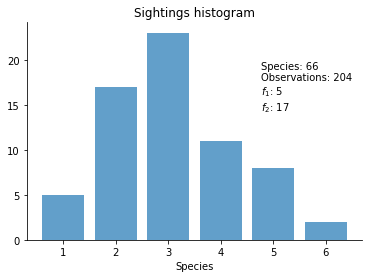

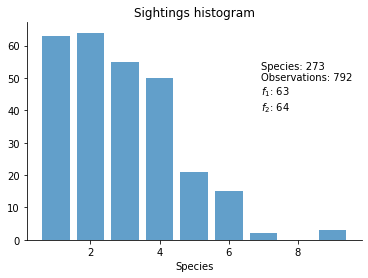

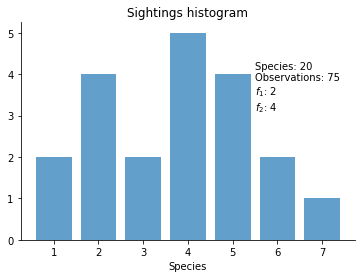

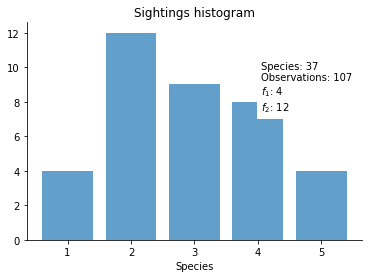

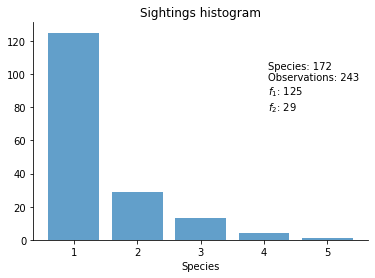

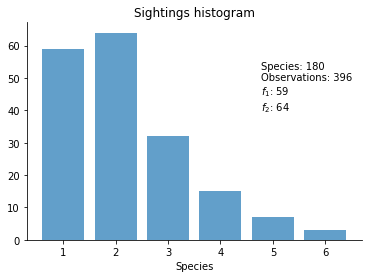

In [125]:
# fast viz: sightings hist

for genre, df in groups.items():
    print(genre)
    abundance = u.to_abundance(df['work'])
    abundance_histogram(abundance)

In [121]:
import inspect

inspect.getargspec(abundance_histogram).args

/var/folders/vf/dhn9ykks0l967yj396ph6x9h0000gn/T/ipykernel_54213/3008140766.py:3: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  inspect.getargspec(abundance_histogram).args


['x', 'ax', 'figsize', 'trendline']

alm_


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.29it/s]


col_lyr


100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.02s/it]

col_nar



 10%|████▍                                       | 1/10 [00:01<00:09,  1.08s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/stats.py:166: RuntimeWarning: invalid value encountered in double_scalars
  A = n * f0 / (n * f0 + f1)
100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.52it/s]

sep_drama



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.11it/s]


sep_lyr


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.17it/s]


sep_nar


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.40it/s]


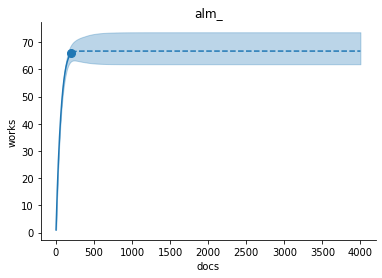

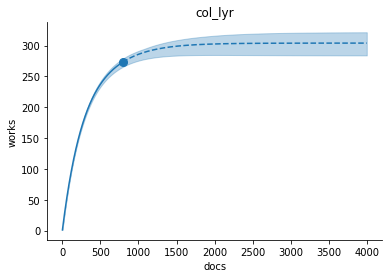

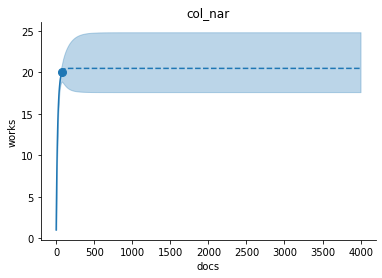

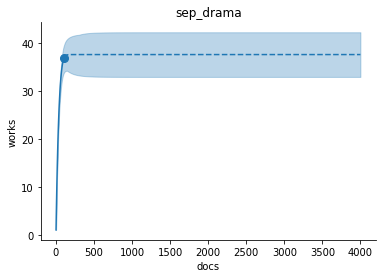

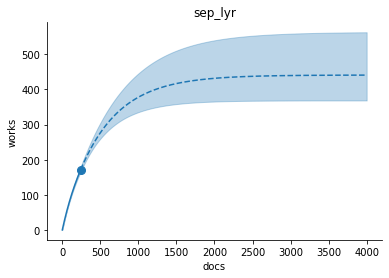

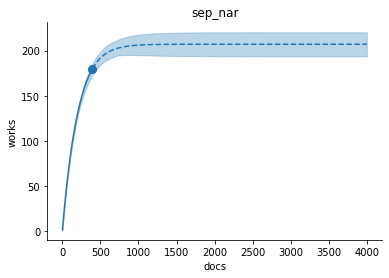

In [123]:
# accumulation curves

for genre, df in groups.items():
    #print(genre)
    abundance = u.to_abundance(df['work'])
    accumulation = species_accumulation(abundance, max_steps = 4000, n_iter = 10)
    accumulation_curve(abundance, accumulation, 
                       xlabel = 'docs', ylabel = 'works',
                       title = genre)

### Fast test: time differences for genres

In [96]:
groups_t = {}
df_t = None

# import all separate .csv tables for the experiment as a dictionary of tables

for fh in sorted(glob.glob('/Users/tonya/Documents/thesis1830s/22_02_poetry_collections_biblio/github_main/data/experiment/genres_decades/*.csv')):
    df_t = pd.read_csv(fh)
    df_t = df_t.iloc[:,1:]
    genre = os.path.basename(fh).replace('.csv','').replace('exp_','').lower()
    groups_t[genre] = df_t[['work', 'signature']]

In [97]:
groups_t

{'col_lyr_1830':                                                   work   signature
 0    5_Батюшков К._Сочинения в прозе и стихах Конст...       nlr_1
 1    5_Батюшков К._Сочинения в прозе и стихах Конст...         rsl
 2    5_Батюшков К._Сочинения в прозе и стихах Конст...       roz_1
 3    5_Батюшков К._Сочинения в прозе и стихах Конст...  us_harvard
 4    5_Батюшков К._Сочинения в прозе и стихах Конст...      cz_slk
 ..                                                 ...         ...
 383  634_Крылов И._Басни Ивана Крылова : В 8 кн. / ...       nlr_1
 384  634_Крылов И._Басни Ивана Крылова : В 8 кн. / ...         rsl
 385  639_NA_Утренняя звезда : Собрание статей в сти...       nlr_1
 386  639_NA_Утренняя звезда : Собрание статей в сти...       fi_sl
 387  684_Хлебников Н._Подарок друзьям в Новый год :...       nlr_1
 
 [388 rows x 2 columns],
 'col_lyr_1840':                                                   work signature
 0    303_Анордист Н._Альманах на 1840 год / Н. Анор...    

In [98]:
# Basic stats calculation

stats_t = []

for genre, df in groups_t.items():
    abundance = u.to_abundance(df['work']) # convert to abundance data
    s = u.basic_stats(abundance) # basic stats function
    d = {'group': genre}
    # take f3 and f4 for well-survived groups
    for k in ('f1', 'f2', 'f3', 'f4', 'S', 'n'):
        d[k] = s[k]
    d['lib'] = len(set(df['signature']))
    stats_t.append(d)
    
# Conversion to df for easier use
stats_t_df = pd.DataFrame(stats_t)
stats_t_df

,group,f1,f2,f3,f4,S,n,lib
0,col_lyr_1830,21,32,24,24,123,388,10
1,col_lyr_1840,20,18,14,16,83,241,9
2,col_lyr_1845,22,14,17,10,67,163,8
3,sep_nar_1830,10,19,13,13,62,177,9
4,sep_nar_1840,29,25,6,2,64,115,9
5,sep_nar_1845,20,20,13,0,54,104,6


In [103]:
populations_t = {}

for genre, df in groups_t.items():
    abundance = u.to_abundance(df_t['work'])
    populations_t[genre.title()] = abundance
    
wsurvival_t = {}
for genre, population in populations_t.items():
    wsurvival[genre] = survival_ratio(population, method = 'chao1')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 840.54it/s]


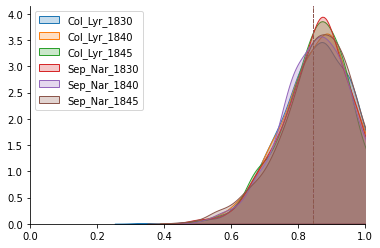

In [104]:
surv_density_w = multi_kde(wsurvival)